## Setup

In [1]:
%%javascript
MathJax.Hub.Config({
      TeX: { equationNumbers: { autoNumber: "AMS" } }
    });MathJax.Hub.Queue(
  ["resetEquationNumbers", MathJax.InputJax.TeX],
  ["PreProcess", MathJax.Hub],
  ["Reprocess", MathJax.Hub]
);
MathJax.Hub.Queue(
  ["resetEquationNumbers", MathJax.InputJax.TeX],
  ["PreProcess", MathJax.Hub],
  ["Reprocess", MathJax.Hub]
);

<IPython.core.display.Javascript object>

In [2]:
from math import exp
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# Introduction

This notebook will demonstrate how to use the code in the `nnpde1.py` module. The module allows the user to solve an arbitrary 1st-order partial differential equation (PDE) initial value problem (IVP) with two variables, and Dirichlet initial conditions, using a single-hidden layer neural network.

This work is based on the paper ["Artificial Neural Networks for Solving Ordinary and Partial Differential Equations", by Lagaris et al, *IEEE Transactions on Neural Networks, Volume 9, No. 5*, September 1998](http://ieeexplore.ieee.org/document/712178/). Note that the notation used in this notebook and the associated Python code differs slightly from that used in the Lagaris paper.

## The algorithm

Consider an $m$-dimensional space containing vectors $\vec x = (x_1,x_2,...,x_m)$. Any 1st-order PDE for the scalar function $\psi(\vec x)$ can be written in the form:

\begin{equation}
G(\vec x,\psi,\vec \nabla \psi) = 0
\end{equation}

The problem is to find a suitable solution to the PDE using a neural network.

The network is trained using a set of $n$ training points $\vec x_i$ ($1 \leq i \leq n$). This work assumes that the vectors $\vec x_i$ have been scaled so that each component $x_{ij} \in [0,1]$, $1 \leq j \leq m$. The training points need not be evenly-spaced. Note that only the independent variable vectors $\vec x_i$  of the training points are needed - the estimated value of the solution at the training points is obtained using a trial solution $\psi_t$ of the form:

\begin{equation}
\psi_t(\vec x_i,\vec p) = A(\vec x_i) + P(\vec x_i) N(\vec x_i,\vec p)
\end{equation}

or:

\begin{equation}
\psi_{ti} = A_i + P_i N_i
\end{equation}

where $\psi_{ti}$ is the value of the trial solution at the current training point $\vec x_i$, $A_i$ is a function which yields the initial conditions at the origin of each dimension, $P_i$ is a function which vanishes at the origin of each dimension, and $N_i$ is the floating-point single-valued output from an unspecified neural network with network parameters $\vec p$. Note that this trial solution satisfies the boundary conditions by construction - at any boundary, the second term vanishes, leaving $\psi_t(\vec x_i, \vec p_i)=A(\vec x_i)$, which is just the specified boundary condition on that boundary. The PDE is assumed to have been preprocessed so that the boundary conditions lie at the origin. For a 2-variable PDE with independent variables $x$ and $y$, this condition is represented by:

\begin{equation}
\psi_t(0,y,\vec p) = f_0(y)
\end{equation}

\begin{equation}
\psi_t(x,0,\vec p) = g_0(x)
\end{equation}

The analytical forms of $A(\vec x_i)$ and $P(\vec x_i)$ are constructed to meet these requirements, and noting that, by continuity at the origin, $f_0(0)=g_0(0)$. For a 2-variable PDE, we have:

\begin{equation}
A(x,y) = (1-x)f_0(y) + (1-y)(g_0(x) - (1-x)g_0(0))
\end{equation}

\begin{equation}
P(x,y) = xy
\end{equation}

These functions rapidly become more complex as the number of problem dimensions is increased, so this example will utilize a 2-variable PDE. Training is done in a set of *epochs*. A training epoch consists of presenting the neural network with each of the $n$ training points $\vec x_i$, one at a time. For each input point $\vec x_i$, the network output $N_i$ is computed. Once all $n$ points have been presented, the epoch is complete, and the error function $E$ is computed. The problem definition provides an analytical form for the error function, as the sum of squared errors (SSE) for each of the training points:

\begin{equation}
E = \sum_{i=1}^{n} \left( G(\vec x_i,\psi_{ti}, \vec \nabla \psi_{ti}) \right)^2 =
\sum_{i=1}^{n} G_i^2
\end{equation}

Once this error function is computed, the parameters in the neural network are adjusted to reduce the error. Eventually, a minimum of $E$ is attained, and the resulting final form of $\psi_t(x)$ is used as the solution to the original PDE.

## Computing the network output $N_i$

The neural network used in this work has a simple structure. One input node for each component of $\vec x_i$ is used (for a total of $m$ input nodes) to provide the training data. Each input node is fully-connected to each of a set of $H$ hidden nodes, each using a sigmoid transfer function. Each hidden node is connected to the single output node, which uses a linear transfer function with a weight for the signal from each hidden node.

During each step of a training epoch, the input to the network is just the training point $\vec x_i$. Each input node $j$ receives one component $x_{ij}$, and emits that value as output. These outputs are sent to each of the $H$ hidden nodes. At each hidden node $k$, the input values $x_{ij}$ are combined and scaled by the equation:

\begin{equation}
z_{ik} = \sum_{j=1}^m w_{jk} x_{ij} + u_k
\end{equation}

where  $w_{jk}$ is the weight for input node $j$ at hidden node $k$, and $u_k$ is the bias at hidden node $k$. This combined value is then used as the input to a sigmoidal transfer function:

\begin{equation}
\sigma_{ik} = \sigma(z_{ik})
\end{equation}

where:

\begin{equation}
\sigma(z) = \frac {1}{1+e^{-z}}
\end{equation}

A plot of this transfer function and its first three derivatives is provided below.

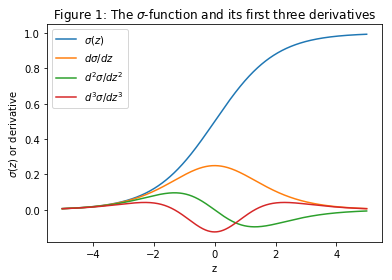

In [3]:
def sigma(z):
    return 1 / (1 + exp(-z))

def dsigma_dz(z):
    return exp(-z) / (1 + exp(-z))**2

def d2sigma_dz2(z):
    return (
        2 * exp(-2 * z) / (1 + exp(-z))**3 - exp(-z) / (1 + exp(-z))**2
    )

def d3sigma_dz3(z):
    return (
        6 * exp(-3 * z) / (1 + exp(-z))**4
        - 6 * exp(-2 * z) / (1 + exp(-z))**3
        + exp(-z) / (1 + exp(-z))**2
    )

z = np.arange(-5, 5, 0.01)
n = len(z)
s = np.zeros(n)
ds_dz = np.zeros(n)
d2s_dz2 = np.zeros(n)
d3s_dz3 = np.zeros(n)
for i in range(n):
    s[i] = sigma(z[i])
    ds_dz[i] = dsigma_dz(z[i])
    d2s_dz2[i] = d2sigma_dz2(z[i])
    d3s_dz3[i] = d3sigma_dz3(z[i])
plt.plot(z,s,label = "$\sigma(z)$")
plt.plot(z,ds_dz,label = "$d\sigma/dz$")
plt.plot(z,d2s_dz2, label = "$d^2\sigma/dz^2$")
plt.plot(z,d3s_dz3, label = "$d^3\sigma/dz^3$");
plt.xlabel("z")
plt.ylabel("$\sigma(z)$ or derivative")
plt.title("Figure 1: The $\sigma$-function and its first three derivatives")
plt.legend();

Once the $\sigma_{ik}$ are computed, they are all passed to the single output node, where they are processed by a linear transfer function to create the network output for the current input point $\vec x_i$:

\begin{equation}
N_i = \sum_{k=1}^{H}v_k\sigma_{ik}
\end{equation}

where $v_k$ is the weight applied to the output from hidden node $k$ at the output node. Once $N_i$ has been computed, the trial function $\psi_{ti}$ is computed. To compute the value of $G_i$ (and thus $E$), we also need the gradient of the trial function $\vec \nabla \psi_{ti}$.

\begin{equation}
\vec \nabla \psi_{ti} = \vec \nabla (A_i + P_i N_i)
\end{equation}

Each component $j$ of this gradient may be written as:

\begin{equation}
\frac {\partial \psi_{ti}}{\partial x_{ij}} =
\frac {\partial A_i}{\partial x_{ij}} + P_i \frac {\partial N_i}{\partial x_{ij}} + \frac {\partial P_i}{\partial x_{ij}} N_i
\end{equation}

The functional forms of the derivatives of $A_i$ and $P_i$ with respect to $x_{ij}$ are computed $\it a \ priori$ from their known analytical forms, which may vary based on the problem under investigation. The values of the network output derivatives $\frac {\partial N_i}{\partial x_{ij}}$ are computed analytically using the known form of the network and its weights and biases.

\begin{equation}
\frac {\partial N_i}{\partial x_{ij}} =
\frac {\partial}{\partial x_{ij}} \sum_{k=1}^{H} v_k \sigma_{ik} =
\sum_{k=1}^{H} v_k \frac {\partial \sigma_{ik}}{\partial x_{ij}} =
\sum_{k=1}^{H} v_k \frac {\partial \sigma_{ik}}{\partial z_{ik}} \frac {\partial z_{ik}}{\partial x_{ij}} = \sum_{k=1}^{H} v_k \sigma_{ik}^{(1)} w_{jk}
\end{equation}

where the derivatives of $\sigma$ are given by:

\begin{equation}
\sigma^{(k)} = \frac {d^k \sigma}{dz^k}
\end{equation}

With the values of $\psi_{ti}$ and $\vec \nabla \psi_{ti}$, we can now compute the values of $G_i$, and then the error function $E$ for the current epoch.

## Updating the network parameters

The network parameters are the weights and biases of the hidden and output nodes. For an $m$-dimensional input point $\vec x_i$, and a set of $H$ hidden nodes, we have a total of $N_p = (m+2)H$ parameters in total: a weight for each $x_{ij}$ for each hidden node, a bias for each hidden node, and an output weight for each hidden node.

Since the objective function to minimize is the error $E$, the value of each network parameter $p$ (where $p$ represents $v_k$, $u_k$, or $w_{jk}$) is updated using a scaled Newton's method:

\begin{equation}
p_{new}=p - \eta \frac {\frac {\partial E}{\partial p}} {\frac {\partial^2 E}{\partial p^2}}
\end{equation}

where $\eta$ is the *learning rate* (usually $\eta < 1$). The learning rate is used to reduce the chance of solution instability due to large values of the correction factor in Newton's method. The derivatives of $E$ are computed using the known form of $G_i$, the network, and the network parameters.

This process of parameter updates is repeated until the specified maximum number of training epochs has been applied. Note that the same set of training points is presented during each epoch.

## Computing the derivatives of $E$

The partial derivatives of $E$ with respect to any network parameter $p$ are given by:

\begin{equation}
\frac {\partial E}{\partial p} =
2 \sum_{i=1}^n G_i \frac {\partial G_i}{\partial p}
\end{equation}

\begin{equation}
\frac {\partial^2 E}{\partial p^2} =
2 \sum_{i=1}^n \left[G_i \frac {\partial^2 G_i}{\partial p^2} + \left(\frac {\partial G_i}{\partial p} \right)^2 \right]
\end{equation}

## Computing the derivatives of $G_i$

The partial derivatives of $G_i$ with respect to $x_{ij}$, $\psi_{ti}$, and $\frac {\partial \psi_{ti}} {\partial x_{ij}}$ are determined $\it a\ priori$ from the analytical form of $G$. Note also that $\frac {\partial x_{ij}} {\partial p_{hk}} = 0$. The remaining partial derivatives of $G_i$ are:

\begin{equation}
\frac {\partial G_i}{\partial p} =
\frac {\partial G_i}{\partial \psi_{ti}} \frac {\partial \psi_{ti}}{\partial p} +
\sum_{j=1}^m \frac {\partial G_i}{\partial \left(\frac {\partial \psi_{ti}}{\partial x_{ij}}\right)}
\frac {\partial^2 \psi_{ti}}{\partial p \partial x_{ij}}
\end{equation}

\begin{equation}
\frac {\partial^2 G_i}{\partial p^2} =
\frac {\partial G_i}{\partial \psi_{ti}}
\frac {\partial^2 \psi_{ti}}{\partial p^2} +
\frac {\partial} {\partial p} \left ( \frac {\partial G_i} {\partial \psi_{ti}} \right ) \frac {\partial \psi_{ti}} {\partial p} +
\sum_{j=1}^m
\left [
\frac {\partial G_i} {\partial \left ( \frac {\partial \psi_{ti}} {\partial x_{ij}} \right ) }
\frac {\partial \psi_{ti}^3} {\partial p^2 \partial x_{ij}} +
\frac {\partial} {\partial p} \left ( \frac {\partial G_i} {\partial \frac {\partial \psi_{ti}} {\partial x_{ij}}} \right )
\frac {\partial \psi_{ti}^2} {\partial p \partial x_{ij}}
\right ]
\end{equation}

Note that the partials of $G_i$ by $\vec x$, $\psi$, and $\vec \nabla \psi$ must be supplied in anaytical form, since the analytical form of $G_i(\vec x,\psi,\vec \nabla \psi)$ is known. Partials of these partials by parameters $p$ are found using the chain rule, as they are for $G_i$ itself.

## Computing the derivatives of $\psi_{ti}$

 The derivatives of the trial solution $\psi_{t}$ are given by:

\begin{equation}
\frac {\partial \psi_{ti}} {\partial p} = \
P_i \frac {\partial N_i} {\partial p}
\end{equation}

\begin{equation}
\frac {\partial^2 \psi_{ti}} {\partial p^2} = \
P_i \frac {\partial^2 N_i} {\partial p^2}
\end{equation}

\begin{equation}
\frac {\partial^2 \psi_{ti}} {\partial p \partial x_{ij}} = \
P_i \frac {\partial^2 N_i} {\partial p \partial x_{ij}} + \
\frac {\partial P_i} {\partial x_{ij}} \frac {\partial N_i} {\partial p}
\end{equation}

\begin{equation}
\frac {\partial^3 \psi_{ti}} {\partial p^2 \partial x_{ij}} = \
P_i \frac {\partial^3 N_i} {\partial p^2 \partial x_{ij}} + \
\frac {\partial P_i} {\partial x_{ij}} \frac {\partial^2 N_i} {\partial p^2}
\end{equation}

Note that $A_i$ and $P_i$ are independent of the network parameters $p$.

## Computing the derivatives of $N_i$

The partial derivatives of $N_i$ are:

\begin{equation}
\frac {\partial N_i} {\partial x_{ij}} = \sum_{k=1}^H v_k \sigma_{ik}^{(1)} w_{jk}
\end{equation}

\begin{equation}
\frac {\partial N_i} {\partial p} =
\sum_{k=1}^H \left ( v_k \sigma_{ik}^{(1)} \frac {\partial z_{ik}} {\partial p} +
\frac {\partial v_k} {\partial p} \sigma_{ik} \right )
\end{equation}

\begin{equation}
\frac {\partial^2 N_i}{\partial p^2} =
\sum_{k=1}^H \left(
v_k \sigma_{ik}^{(2)} \left( \frac {\partial z_{ik}}{\partial p} \right)^2 +
2 \frac {\partial v_k}{\partial p} \sigma_{ik}^{(1)} \frac {\partial z_{ik}}{\partial p} 
\right)
\end{equation}

\begin{equation}
\frac {\partial^2 N_i}{\partial p \partial x_{ij}} =
\sum_{k=1}^{H} \left(
v_k \sigma_{ik}^{(1)} \frac {\partial w_{jk}} {\partial p} + \
v_k \sigma_{ik}^{(2)} \frac {\partial z_{ik}} {\partial p} w_{jk} + \
\frac {\partial v_k} {\partial p} \sigma_{ik}^{(1)} w_{jk}
\right)
\end{equation}

\begin{equation}
\frac {\partial^3 N_i}{\partial p^2 \partial x_i} =
\sum_{k=1}^H
\left(
v_k \sigma_{ik}^{(2)} \frac {\partial z_{ik}} {\partial p} \frac {\partial w_{jk}} {\partial p} +
\frac {\partial v_k} {\partial p} \sigma_{ik}^{(1)} \frac {\partial w_{jk}} {\partial p} +
v_k \sigma_{ik}^{(2)} \frac {\partial z_{ik}} {\partial p} \frac {\partial w_{jk}} {\partial p} +
v_k \sigma_{ik}^{(3)} \left( \frac {\partial z_{ik}} {\partial p} \right)^2 w_{jk} +
\frac {\partial v_k} {\partial p} \sigma_{ik}^{(2)} \frac {\partial z_{ik}} {\partial p} w_{jk} +
\frac {\partial v_k} {\partial p} \sigma_{ik}^{(1)} \frac {\partial w_{jk}} {\partial p} +
\frac {\partial v_k} {\partial p} \sigma_{ik}^{(2)} \frac {\partial z_{ik}} {\partial p} w_{jlk}
\right)
\end{equation}

Most of these expressions can now be simplified using the following relations between the network parameters ($*$ means any index or combination of indices):

\begin{equation}
\frac {\partial v_k}{\partial v_l} = \delta_{kl},
\frac {\partial v_k}{\partial w_*} = \frac {\partial v_k}{\partial u_*} = 0
\end{equation}


\begin{equation}
\frac {\partial u_k}{\partial u_l} = \delta_{kl},
\frac {\partial u_k}{\partial v_*} = \frac {\partial u_k}{\partial w_*} = 0
\end{equation}

\begin{equation}
\frac {\partial w_{jk}}{\partial w_{hl}} = \delta_{jh} \delta_{kl},
\frac {\partial w_{jk}}{\partial v_*} = \frac {\partial w_{jk}}{\partial u_*} = 0
\end{equation}

\begin{equation}
\frac {\partial z_{ik}}{\partial v_*} = 0,
\frac {\partial z_{ik}}{\partial w_{jl}} = x_{ij} \delta_{kl},
\frac {\partial z_{ik}}{\partial u_l} = \delta_{kl},
\end{equation}

# Walking through an example problem

Consider the simple 1st-order partial differential equation:

\begin{equation}
G(\vec x, \psi, \vec \nabla \psi) = xy + 1 - \psi = 0
\end{equation}

In Python form:

In [4]:
def Gf(xy, psi, del_psi):
    (x, y) = xy
    (dpsi_dx, dpsi_dy) = del_psi
    return x*y + 1 - psi

The analytical solution to this PDE is:

\begin{equation}
\psi(x,y) = xy + 1
\end{equation}

This function is plotted in the following figure:

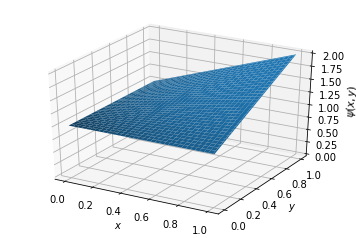

In [5]:
fig = plt.figure()
ax = fig.gca(projection = '3d')
x = np.linspace(0,1,101)
y = np.linspace(0,1,101)
x,y = np.meshgrid(x,y)
psi = x*y + 1
z = psi.reshape(x.shape)
surf = ax.plot_surface(x, y, z)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlim3d(0, 2)
ax.set_zlabel('$\psi(x,y)$');

We need to specify quite a few derivatives, but most of them vanish. To begin, the first partials of $G(\vec x,\psi,\vec \nabla \psi)$:

\begin{equation}
\frac {\partial G} {\partial x} = y
\end{equation}

\begin{equation}
\frac {\partial G} {\partial y} = x
\end{equation}

In Python form, these equations are (unused arguments are ignored):

In [6]:
def dG_dxf(xy,psi,del_psi):
    (x,y) = xy
    return y

In [7]:
def dG_dyf(xy, psi, del_psi):
    (x, y) = xy
    return x

In [8]:
del_Gf = (dG_dxf,dG_dyf)

\begin{equation}
\frac {\partial G} {\partial \psi} = -1
\end{equation}

In Python form:

In [9]:
def dG_dpsif(xy, psi, del_psi):
    return -1

\begin{equation}
\frac {\partial G} {\partial \left ( \frac {\partial \psi} {\partial x} \right )} = 0
\end{equation}

\begin{equation}
\frac {\partial G} {\partial \left ( \frac {\partial \psi} {\partial y} \right )} = 0
\end{equation}

In Python form:

In [10]:
def dG_dpsi_dxf(xy, psi, del_psi):
    (dpsi_dx, dpsi_dy) = del_psi
    return 0

In [11]:
def dG_dpsi_dyf(xy, psi, del_psi):
    (dpsi_dx, dpsi_dy) = del_psi
    return 0

In [12]:
dG_ddel_psif = (dG_dpsi_dxf,dG_dpsi_dyf)

The required second partials are:

\begin{equation}
\frac {\partial^2 G} {\partial \psi^2} = 0
\end{equation}

In [13]:
def d2G_dpsi2f(xy, psi, del_psi):
    return 0

\begin{equation}
\frac {\partial^2 G} {\partial \left ( \frac {\partial \psi} {\partial x} \right ) \partial \psi} = 0
\end{equation}

\begin{equation}
\frac {\partial^2 G} {\partial \left ( \frac {\partial \psi} {\partial y} \right ) \partial \psi} = 0
\end{equation}

In [14]:
def d2G_ddxdpsif(xy, psi, del_psi):
    return 0

In [15]:
def d2G_ddydpsif(xy, psi, del_psi):
    return 0

In [16]:
d2G_ddel_psi_dpsif = (d2G_ddxdpsif, d2G_ddydpsif)

\begin{equation}
\frac {\partial^2 G} { \partial \psi \partial \left ( \frac {\partial \psi} {\partial x} \right )} = 0
\end{equation}

\begin{equation}
\frac {\partial^2 G} { \partial \psi \partial \left ( \frac {\partial \psi} {\partial y} \right )} = 0
\end{equation}

In [17]:
def d2G_dpsiddx(xy, psi, del_psi):
    return 0

In [18]:
def d2G_dpsiddy(xy, psi, del_psi):
    return 0

In [19]:
d2G_dpsi_ddel_psif = (d2G_dpsiddx, d2G_dpsiddy)

\begin{equation}
\frac {\partial^2 G} { \partial \left ( \frac {\partial \psi} {\partial x} \right )^2} = 0
\end{equation}

\begin{equation}
\frac {\partial^2 G} { \partial \left ( \frac {\partial \psi} {\partial y} \right )^2} = 0
\end{equation}

In [20]:
def d2G_ddx2f(xy, psi, del_psi):
    return 0

In [21]:
def d2G_ddy2f(xy, psi, del_psi):
    return 0

In [22]:
d2G_ddel_psi2f = (d2G_ddx2f, d2G_ddy2f)

The boundary condition functions and their required derivatives are:

\begin{equation}
f_0(y)=1
\end{equation}

\begin{equation}
g_0(x)=1
\end{equation}

In [23]:
def f0f(y):
    return 1

In [24]:
def g0f(x):
    return 1

In [25]:
bcf = (f0f,g0f)

\begin{equation}
\frac {\partial f_0} {\partial y} = 0
\end{equation}

\begin{equation}
\frac {\partial g_0} {\partial x} = 0
\end{equation}

In [26]:
def df0_dyf(y):
    return 0

In [27]:
def dg0_dxf(x):
    return 0

In [28]:
bcdf = (df0_dyf, dg0_dxf)

Now that we have the forms for all of these derivatives and boundary conditions, we can create the training points. Use an evenly-spaced grid of 25 points.

In [29]:
nxy = 5
dxy = 1 / nxy
x = np.zeros((nxy**2, 2))
for j in range(nxy):
    for i in range(nxy):
        k = j * nxy + i
        x[k][0] = i * dxy
        x[k][1] = j * dxy

Call the function which solves the ODE. Use 10 nodes in the hidden layer, and 1000 training epochs, a learning rate of 0.01, and activate verbose output.

In [30]:
from nnpde1 import nnpde1
(psit,del_psi) = nnpde1(
        Gf,             # 2-variable, 1st-order PDE IVP to solve
        bcf,            # BC functions
        bcdf,           # BC function derivatives
        dG_dpsif,       # Partial of G wrt psi
        del_Gf,         # Gradient of G
        dG_ddel_psif,   # Partials of G wrt del psi
        d2G_dpsi2f,     # 2nd partial wrt psi
        d2G_ddel_psi_dpsif, # Cross-partials
        d2G_dpsi_ddel_psif, # Cross-partials
        d2G_ddel_psi2f, # 2nd partial wrt del psi
        x,              # Training points as pairs
        nhid = 10,      # Node count in hidden layer
        maxepochs = 1000, # Max training epochs
        eta = 0.01,     # Learning rate
        debug = False,
        verbose = True
    )

0 14.366940681920905
1 12.903942855394568
2 11.131235523709408
3 9.585595548555386
4 8.263130127143333
5 7.140251961827375
6 6.190020438303888
7 5.3868389182633605
8 4.70789395647287
9 4.133446139081688
10 3.646683932377524
11 3.2334195138229074
12 2.8817445720633152
13 2.58169678981726
14 2.3249575452597284
15 2.1045873343544814
16 1.9147988872926627
17 1.7507650615074555
18 1.6084575048185257
19 1.4845118829237651
20 1.3761156891767348
21 1.2809150592199434
22 1.1969374732034628
23 1.1225276808101237
24 1.0562945994799107
25 0.9970673025096792
26 0.9438585290999885
27 0.8958344157416217
28 0.8522893725467822
29 0.812625214887428
30 0.7763338155682385
31 0.7429826708263705
32 0.7122028791857586
33 0.6836791194252203
34 0.6571412858655397
35 0.6323574985208891
36 0.6091282546119643
37 0.5872815283305679
38 0.5666686590834841
39 0.5471608959664216
40 0.5286464889462277
41 0.5110282360015874
42 0.49422141098111066
43 0.47815200975380606
44 0.4627552628210994
45 0.4479743713201145
46 0.43

335 5.849166433217532e-07
336 5.759704148454168e-07
337 5.670999565076795e-07
338 5.583065889054163e-07
339 5.495915526853001e-07
340 5.409560106918601e-07
341 5.324010500690167e-07
342 5.239276843119409e-07
343 5.155368552765347e-07
344 5.072294351365999e-07
345 4.990062283033888e-07
346 4.90867973296645e-07
347 4.828153445754757e-07
348 4.748489543282473e-07
349 4.669693542230652e-07
350 4.5917703712019515e-07
351 4.5147243874640343e-07
352 4.438559393374909e-07
353 4.3632786524272415e-07
354 4.288884905003831e-07
355 4.21538038378772e-07
356 4.142766828894723e-07
357 4.0710455027010676e-07
358 4.000217204412742e-07
359 3.930282284325749e-07
360 3.8612406578634933e-07
361 3.793091819362939e-07
362 3.7258348555887573e-07
363 3.659468459035004e-07
364 3.5939909409952404e-07
365 3.5294002444036355e-07
366 3.465693956480241e-07
367 3.4028693211283906e-07
368 3.340923251163838e-07
369 3.2798523403180115e-07
370 3.2196528750491874e-07
371 3.160320846166433e-07
372 3.101851960236984e-07
373

648 7.515530220966845e-10
649 7.34981962538103e-10
650 7.187785784825323e-10
651 7.029347108958356e-10
652 6.874423807307226e-10
653 6.722937850941473e-10
654 6.57481293344932e-10
655 6.429974433527068e-10
656 6.288349377809504e-10
657 6.149866405131191e-10
658 6.014455731085879e-10
659 5.882049113784665e-10
660 5.752579819492249e-10
661 5.625982590285755e-10
662 5.502193611125143e-10
663 5.381150478983217e-10
664 5.262792171071676e-10
665 5.147059015076375e-10
666 5.03389265973915e-10
667 4.923236045170676e-10
668 4.81503337530266e-10
669 4.709230089819965e-10
670 4.605772836770252e-10
671 4.504609446626322e-10
672 4.4056889057064376e-10
673 4.3089613313983317e-10
674 4.214377946881911e-10
675 4.121891056835471e-10
676 4.0314540239906374e-10
677 3.9430212454819124e-10
678 3.856548130484123e-10
679 3.7719910775068526e-10
680 3.689307452983328e-10
681 3.6084555698385254e-10
682 3.529394666683339e-10
683 3.4520848872638875e-10
684 3.3764872607526637e-10
685 3.3025636821485787e-10
686 3.2

959 1.083168727526294e-12
960 1.0622773877915867e-12
961 1.041798545124629e-12
962 1.021723849051523e-12
963 1.0020451246010537e-12
964 9.827543646893148e-13
965 9.638437281197607e-13
966 9.453055374434185e-13
967 9.271322732361319e-13
968 9.093165722520779e-13
969 8.9185122370389e-13
970 8.747291655945148e-13
971 8.579434816497771e-13
972 8.414873993242801e-13
973 8.253542851109413e-13
974 8.095376432080367e-13
975 7.940311107529668e-13
976 7.788284574520154e-13
977 7.639235797525913e-13
978 7.493105015865881e-13
979 7.349833680679984e-13
980 7.209364464004311e-13
981 7.071641203826049e-13
982 6.936608902072408e-13
983 6.804213682037539e-13
984 6.674402781275e-13
985 6.547124515227568e-13
986 6.422328256732199e-13
987 6.299964424051399e-13
988 6.179984446499754e-13
989 6.062340745956684e-13
990 5.946986721628057e-13
991 5.833876723945199e-13
992 5.722966034178021e-13
993 5.614210856143294e-13
994 5.507568280929662e-13
995 5.402996273349067e-13
996 5.300453663014888e-13
997 5.199900111

Compare the computed values with the analytical values.

In [40]:
def psiaf(xy):
    (x, y) = xy
    return x*y + 1

In [41]:
def dpsia_dxf(xy):
    (x, y) = xy
    return y

In [42]:
def dpsia_dyf(xy):
    (x, y) = xy
    return x

In [43]:
del_psiaf = ( dpsia_dxf, dpsia_dyf )

In [44]:
psia = np.zeros(len(x))
for i in range(len(x)):
    psia[i] = psiaf(x[i])

In [45]:
del_psia = np.zeros((len(x), len(x[1])))
for i in range(len(x)):
    for j in range(len(x[0])):
        del_psia[i][j] = del_psiaf[j](x[i])

Compute the RMS error of the computed solution and its partial derivatives.

In [46]:
from math import sqrt
psi_err = psit - psia
rmse_psi = sqrt(sum(psi_err**2) / len(x))

In [47]:
del_psi_err = del_psi - del_psia
rmse_del_psi = np.zeros(len(x[0]))
e2sum = np.zeros(len(x[0]))
for j in range(len(x[0])):
    for i in range(len(x)):
        e2sum[j] += del_psi_err[i][j]**2
    rmse_del_psi[j] = sqrt(e2sum[j] / len(x))

Compare the results.

In [48]:
print('    x        y      psia     psit   dpsia_dx dpsia_dy dpsit_dx dpsit_dy')
for i in range(len(psia)):
    print('%.6f %.6f %.6f %.6f %.6f %.6f %.6f %.6f' %
          (x[i][0], x[i][1],
           psia[i], psit[i],
           del_psia[i][0], del_psi[i][0],
           del_psia[i][1], del_psi[i][1])
        )
print('RMSE      %f          %f     %f' % 
      (rmse_psi, rmse_del_psi[0], rmse_del_psi[1]))

    x        y      psia     psit   dpsia_dx dpsia_dy dpsit_dx dpsit_dy
0.000000 0.000000 1.000000 1.000000 0.000000 0.000000 0.000000 0.000000
0.200000 0.000000 1.000000 1.000000 0.000000 0.000000 0.200000 0.299179
0.400000 0.000000 1.000000 1.000000 0.000000 0.000000 0.400000 0.399993
0.600000 0.000000 1.000000 1.000000 0.000000 0.000000 0.600000 0.599997
0.800000 0.000000 1.000000 1.000000 0.000000 0.000000 0.800000 0.800000
0.000000 0.200000 1.000000 1.000000 0.200000 0.270528 0.000000 0.000000
0.200000 0.200000 1.040000 1.039999 0.200000 0.199972 0.200000 0.199972
0.400000 0.200000 1.080000 1.080000 0.200000 0.200003 0.400000 0.400002
0.600000 0.200000 1.120000 1.120000 0.200000 0.200000 0.600000 0.600000
0.800000 0.200000 1.160000 1.160000 0.200000 0.200000 0.800000 0.800000
0.000000 0.400000 1.000000 1.000000 0.400000 0.399996 0.000000 0.000000
0.200000 0.400000 1.080000 1.080000 0.400000 0.400001 0.200000 0.200002
0.400000 0.400000 1.160000 1.160000 0.400000 0.400000 0.400000 0